In [7]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


root_dir = '/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example'
task_folder = '1UGH_docking'

## calculate HDXRank Score ###
# load prediction #
protein_name = '1UGH'
cluster_id = 1
N_decoys = 1000
cluster = f'cluster{cluster_id}_8A_manual_rescale'
HDX_fpath = f'{root_dir}/{task_folder}/HDX_files/BioChem_UNGUGI.xlsx'
pred_cluster = 2
 
# get average update from source HDX file #
timepoints = [3, 3.2]
summary_fpath = f'{root_dir}/{task_folder}/example_{protein_name}_Dock.xlsx'
complex_batch_list = [f'MODEL_{i}_REVISED' for i in range(1, N_decoys+1)] + [f'MODEL_{i}_NATIVE' for i in range(1, N_decoys+1)]

# get dockq score#
N_decoys = 1000 #len(os.listdir(f'{root_dir}/{protein_name}'))
global_list = [f'MODEL_{i}_REVISED.pdb' for i in range(1, N_decoys+1)]
native_list = [f'MODEL_{i}_NATIVE.pdb' for i in range(1, N_decoys+1)]
model_list = global_list + native_list
mapping = {"A": "A","B": "B"}

In [2]:
## function utilities ##
from scipy.stats import spearmanr
from matplotlib.ticker import AutoMinorLocator

def max_min_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
    
def dockq_criterion(row):
    dockq = row['dockq']
    labels = {'incorrect': 0, 'acceptable': 1, 'medium': 2, 'high': 3}
    if 0.00 <= dockq < 0.23:
        return labels['incorrect']
    elif 0.23 <= dockq < 0.49:
        return labels['acceptable']
    elif 0.49 <= dockq < 0.80:
        return labels['medium']
    elif dockq >= 0.80:
        return labels['high']

def classify_by_dockq(df, dockq_col='dockq'):
    df['dockq'] = df[dockq_col]
    df['classification'] = df.apply(dockq_criterion, axis=1)
    df.drop(columns=['dockq'], inplace=True)
    return df

def plot_score(df, ref_col = 'LRMS', score_col='HDX_score', x_label='LRMS', y_label='HDX_score', protein_name=None, x_max=None, save_fig=False):
    # Calculate Spearman and Pearson correlation
    spearman_corr, _ = spearmanr(df[ref_col], df[score_col])
    
    plt.figure(figsize=(8, 6))
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Scatter plot with different colors for each classification
    palette = {0: '#0273b2', 1: '#019e73', 2: '#de8f06', 3: '#d55e00'}
    legend_labels = {0: 'Incorrect', 1: 'Acceptable', 2: 'Medium', 3: 'High'}
    colors = df['classification'].map(palette)

    plt.scatter(df[ref_col].to_numpy(), max_min_scale(df[score_col].to_numpy()), alpha=0.7, edgecolor='black', c=colors, s=20)
    
    plt.title(f'{protein_name}, SCC: {spearman_corr:.2f}', fontsize=20)
    plt.minorticks_on()
    plt.tick_params(axis='both', labelsize=12)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Set legend with proper labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                         markerfacecolor=palette[i], markersize=10, markeredgecolor='black') for i in range(4)]
    #plt.legend(handles=handles, title='CAPRI Classification')
    
    plt.tight_layout()
    if x_max:
        plt.xlim(-5, x_max)

    if save_fig:
        plt.savefig(f'{root_dir}/{task_folder}/{protein_name}_{y_label}_{x_label}.png', dpi=300)
    else:
        plt.show()

def parse_predictions(n, pred_dir, fsuffix='prediction_HDXRank', col_list=['Y_Pred_short', 'Y_Pred_middle','Y_Pred_long']):
    dfs = []
    for i in range(n):
        fpath = f'{pred_dir}/{fsuffix}_v{i}.csv'
        df = pd.read_csv(fpath)
        print(df.shape)
        dfs.append(df)
    merged_df = pd.concat(dfs, axis=0)
    average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])[col_list].mean().reset_index()
    return average_df

# plot HDX difference and find potential HDX epitopes
def plot_HDX_diff(true_diff, diff_mtx, size=(10, 6)):
    plt.figure(figsize=size)
    x_labels = list(true_diff.keys())
    x_positions = np.arange(len(x_labels))  # numerical positions for x-axis

    diff = np.array(list(true_diff.values()))
    diff_neg = diff[diff<0]
    mean_diff = np.mean(diff_neg)
    hdx_epitope_id = np.where(diff<mean_diff)[0]
    hdx_epitope_pep = [x_labels[i] for i in hdx_epitope_id]

    plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
    all_times = set()
    for diffs in diff_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))
    for time in sorted_times:
        time_values = [diff_mtx[label].get(time, 0) / 100 for label in x_labels]
        plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=1, markersize=4)
    plt.ylabel('RFU difference')
    plt.axhline(y=mean_diff, color='r', linestyle='--', label='Epitope cutoff')
    #plt.grid(True)
    plt.legend()
    plt.show()
    return hdx_epitope_id, hdx_epitope_pep, sorted_times

# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff

def get_true_diff(HDX_fpath, apo_states, complex_states, cluster_id):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        if cluster_id == 0:
            temp_HDX_df = temp_HDX_df[temp_HDX_df['log_t']<timepoints[0]]
        elif cluster_id == 1:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<timepoints[1]) & (temp_HDX_df['log_t']>=timepoints[0])]
        elif cluster_id == 2:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']>=timepoints[1])]
        else:
            raise ValueError('Invalid cluster_id')
        
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                #chain_id = int(row['Chain'])
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_mtx, complex_mtx = {}, {}

    protein, state, correction = apo_states[0], apo_states[1], apo_states[2]
    uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_apo[l] = u
    apo_mtx.update(U_apo_mtx)

    protein, state, correction = complex_states[0], complex_states[1], complex_states[2]
    uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_complex[l] = u
    complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print('Common peptides num:', len(true_diff.keys()))
    return true_diff, diff_mtx

In [22]:
# run DockQ to evaluate the quality of Hdock decoys
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces

def merge_chains(model, chains_to_merge):
    for chain in chains_to_merge[1:]:
        for i, res in enumerate(model[chain]):
            res.id = (chain, res.id[1], res.id[2])
            model[chains_to_merge[0]].add(res)
        model.detach_child(chain)
    model[chains_to_merge[0]].id = "".join(chains_to_merge)
    return model

def run_dockq(protein_name, hdock_dir, model_list, mapping):
    dockq_results = {}
    native = load_PDB(f'/home/lwang/models/HDX_LSTM/data/hdock/structure/{protein_name[:4]}/{protein_name[:4]}.pdb')
    #native = merge_chains(native, ["A", "B"])
    for model in model_list:
        if not model.endswith('.pdb'):
            continue
        model_fpath = f'{hdock_dir}/{model}'
        structure = load_PDB(model_fpath)
        #print(list(structure.get_chains()))
        #print(list(native.get_chains()))
        #structure = merge_chains(structure, ["A", "B"])
        result = run_on_all_native_interfaces(structure, native, chain_map=mapping)
        data = list(result[0].values())[0]
        dockq_results[model.split('.')[0]] = [data['DockQ'], data['irms'], data['Lrms'], data['fnat']]
    return dockq_results

In [126]:
## calculation ##
hdock_dir = f'{root_dir}/{task_folder}/structures/near_native'
dockq_results = run_dockq(protein_name, hdock_dir, native_list, mapping)
dockq_df = pd.DataFrame(dockq_results).T
dockq_df.columns = ['DockQ', 'irms', 'Lrms', 'fnat']
dockq_df['model'] = dockq_df.index

hdock_dir = f'{root_dir}/{task_folder}/structures'
dockq_results = run_dockq(protein_name, hdock_dir, global_list, mapping)
dockq_df2 = pd.DataFrame(dockq_results).T
dockq_df2.columns = ['DockQ', 'irms', 'Lrms', 'fnat']
dockq_df2['model'] = dockq_df2.index
dockq_df = pd.concat([dockq_df, dockq_df2], axis=0)
print(dockq_df.shape)

(2000, 5)


In [3]:
global_pred_df = parse_predictions(5, f'{root_dir}/{task_folder}/predictions', fsuffix='prediction_HDXRank_global')
native_pred_df = parse_predictions(5, f'{root_dir}/{task_folder}/predictions', fsuffix='prediction_HDXRank_native')
pred_df = pd.concat([global_pred_df, native_pred_df], axis=0)

(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)
(126126, 7)


('hUNG', 'apo', -9, '1AKZ') ('hUNG-UGI', 'complex', -9, '1UGH')
Common peptides num: 69


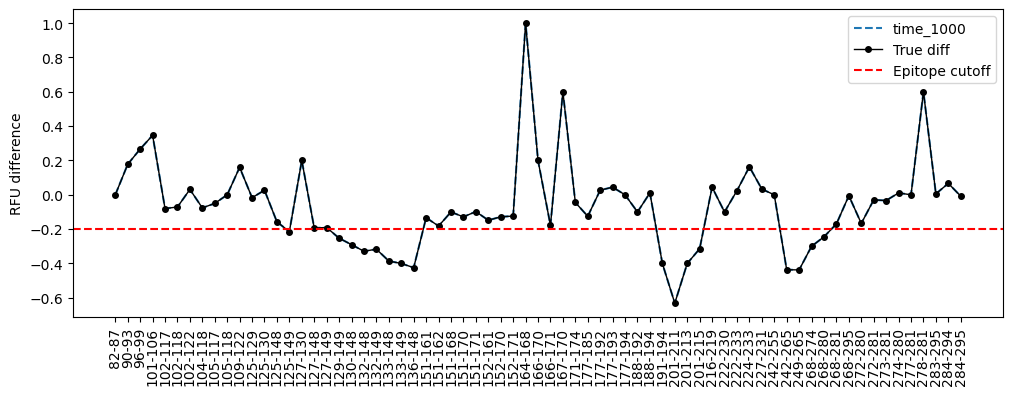

('UGI', 'apo', 0, '1UGI') ('UGI-hUNG', 'complex', 0, '1UGH')
Common peptides num: 57


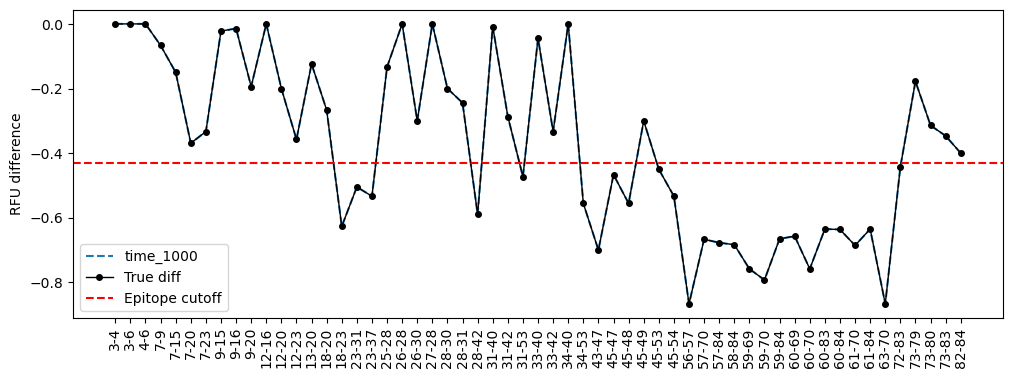

In [8]:
summary_df = pd.read_excel(summary_fpath, sheet_name='Sheet1')
summary_df = summary_df.dropna(subset=['match_uni'])
summary_df = summary_df[(summary_df['note']==task_folder[:4])]
grouped = summary_df.groupby(['match_uni'])

apo_states, complex_states = [], []
for name, group in grouped:
    apo_group = group[group['complex_state'] == 'single']
    complex_group = group[group['complex_state'] == 'protein complex']
    apo_states.append((apo_group['protein'].values[0], apo_group['state'].values[0], apo_group['correction_value'].values[0], apo_group['structure_file'].values[0]))
    complex_states.append((complex_group['protein'].values[0], complex_group['state'].values[0], complex_group['correction_value'].values[0], complex_group['structure_file'].values[0]))

hdx_epitope_peps = []
hdx_true_diffs = []
for apo, complex in zip(apo_states, complex_states):
    print(apo, complex)
    true_diff, diff_mtx = get_true_diff(HDX_fpath, apo, complex, cluster_id)
    epitope_id, epitope_pep, hdx_times = plot_HDX_diff(true_diff, diff_mtx, size=(12,4))
    hdx_true_diffs.append(true_diff)
    hdx_epitope_peps.append(epitope_pep)

In [9]:
# ouput the HDX epitope peptides
def to_ranges(numbers):
    if not numbers:
        return []
    
    ranges = []
    start = numbers[0]
    prev = numbers[0]

    for num in numbers[1:]:
        if num == prev + 1:
            # Continue the current range
            prev = num
        else:
            # End of the current range
            ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
            start = num
            prev = num
    
    # Add the last range
    ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
    return ranges

def to_numbers(range_list):
    all_numbers = set()
    for r in range_list:
        start, end = map(int, r.split('-'))
        all_numbers.update(range(start, end + 1))
    return sorted(all_numbers)

for i, epitopes in enumerate(hdx_epitope_peps):
    all_numbers = to_numbers(epitopes)
    ranges = to_ranges(all_numbers)
    print(f'Epitopes for {apo_states[i][3]} and {complex_states[i][3]}:')
    print(ranges)

Epitopes for 1AKZ and 1UGH:
['125-149', '191-194', '201-215', '242-265', '268-280']
Epitopes for 1UGI and 1UGH:
['18-54', '56-84']


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def root_mean_square_error(y_true, y_pred, error_limit=1):
    return np.mean(((y_true - y_pred) / error_limit) ** 2)

def prepare_data(complex_batch, apo_states, hdx_true_diffs, hdx_epitope_peps=None, pred_cluster=1):
    truth = []
    pred = []
    pred_cluster_dict = {0: 'Y_Pred_short', 1: 'Y_Pred_middle', 2: 'Y_Pred_long'}
    
    if complex_batch not in pred_df_dict:
        return None, None

    if hdx_epitope_peps is None:
        hdx_epitope_peps = [list(hdx_dict.keys()) for hdx_dict in hdx_true_diffs]

    complex_df = pred_df_dict[complex_batch]
    complex_pep_set = set(complex_df['Range'].unique())  # Convert to Set for O(1) lookup
    complex_df = complex_df.groupby('Range', as_index=False)[pred_cluster_dict[pred_cluster]].mean()
    for apo_state, epitope_peps, hdx_dict in zip(apo_states, hdx_epitope_peps, hdx_true_diffs):
        apo_batch = apo_state[-1]
        if apo_batch not in pred_df_dict:
            continue

        apo_df = pred_df_dict[apo_batch]  # Pre-fetched DataFrame
        apo_df = apo_df.groupby('Range', as_index=False)[pred_cluster_dict[pred_cluster]].mean()
        
        apo_pep_set = set(apo_df['Range'].unique())  # Convert to Set for O(1) lookup

        common_peptides = [pep for pep in epitope_peps if pep in apo_pep_set and pep in complex_pep_set]

        if not common_peptides:
            continue

        # Ensure both DataFrames extract values in the same order using .reindex()
        apo_values = apo_df.set_index('Range').reindex(common_peptides)[pred_cluster_dict[pred_cluster]].values
        complex_values = complex_df.set_index('Range').reindex(common_peptides)[pred_cluster_dict[pred_cluster]].values

        # Subtract values
        pred_diffs = complex_values - apo_values
        true_diffs = np.array([hdx_dict[pep] for pep in common_peptides])

        truth.extend(true_diffs)
        pred.extend(pred_diffs)

    return np.array(truth), np.array(pred)

# Precompute pred_df into a dictionary of DataFrames for faster access
pred_df_dict = {batch: group for batch, group in pred_df.groupby('Batch')}

# Precompute unique complex batches
complex_batch_list = list(pred_df_dict.keys())
complex_batch_list = [batch for batch in complex_batch_list if 'MODEL' in batch]

HDX_scores = {}
y_true_list = []
y_pred_list = []
for complex_batch in tqdm(complex_batch_list):
    y_true, y_pred = prepare_data(complex_batch, apo_states, hdx_true_diffs, hdx_epitope_peps=hdx_epitope_peps, pred_cluster=pred_cluster)
    #y_true *= 2
    if y_true is None:
        continue
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    #HDX_scores[complex_batch] = root_mean_square_error(y_true, y_pred)


100%|██████████| 2000/2000 [00:07<00:00, 260.44it/s]

y_true: (84000,)
y_pred: (84000,)


In [12]:
y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)
print('y_true:', y_true.shape)
print('y_pred:', y_pred.shape)

y_true: (2000, 42)
y_pred: (2000, 42)


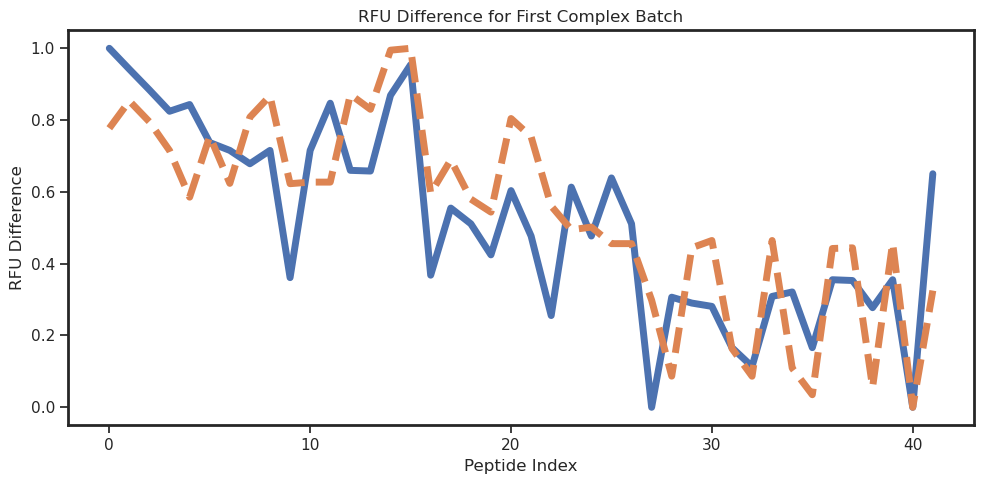

In [50]:
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
import seaborn as sns

sns.set(style="ticks")
plt.figure(figsize=(10, 5))
plt.rcParams['axes.linewidth'] = 2
plt.plot(range(y_true.shape[1]), min_max_scale(y_true[0]),linestyle='-', alpha=1, linewidth=5)
#plt.plot(range(y_pred.shape[1]), min_max_scale(y_pred[1490])[::-1], linestyle='--', alpha=1, linewidth=5)
plt.plot(range(y_pred.shape[1]), min_max_scale(y_pred[1001]), linestyle='--', alpha=1, linewidth=5)
plt.xlabel('Peptide Index')
plt.ylabel('RFU Difference')
plt.title('RFU Difference for First Complex Batch')
#plt.legend(['True', 'Predicted'])
#plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
dockq_df = pd.read_csv('/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/1UGH_docking/HDX_scores.csv')
dockq_df = dockq_df.drop(columns=['HDX_score', 'HDX_time'])
dockq_df.rename(columns={'Batch': 'model'}, inplace=True)
display(dockq_df.head())

,DockQ,irms,Lrms,fnat,classification,model,zrank2_score,zrank_score,rosetta_score
0,0.937331,0.330537,0.741397,0.865854,3,MODEL_90_NATIVE,-274.301,-113.322,-56.587
1,0.948274,0.258822,0.559539,0.878049,3,MODEL_422_NATIVE,-262.176,-115.470,-45.420
2,0.921707,0.400873,0.840492,0.841463,3,MODEL_259_NATIVE,-258.516,-111.084,-146.765
3,0.925841,0.466888,0.944685,0.878049,3,MODEL_554_NATIVE,-287.252,-120.947,-148.475
4,0.958798,0.230526,0.463915,0.902439,3,MODEL_843_NATIVE,-265.795,-112.709,-188.063


,DockQ,irms,Lrms,fnat,classification,model,zrank2_score,zrank_score,rosetta_score,HDX_score
9,0.243587,5.102433,8.940775,0.176471,1,MODEL_646_NATIVE,-235.2370,-92.0898,2427.999,0.025519
3,0.415776,3.229518,6.614724,0.447059,1,MODEL_654_NATIVE,-345.4000,-87.3417,1990.186,0.026070
12,0.744883,1.124420,2.230291,0.658824,2,MODEL_220_NATIVE,-469.7530,-138.2780,1925.313,0.026382
13,0.655936,1.504317,2.761323,0.564706,2,MODEL_334_NATIVE,-553.0880,-181.7190,1931.743,0.026403
5,0.288631,4.140567,7.509359,0.188235,1,MODEL_897_NATIVE,-364.0380,-112.4860,1024.108,0.026857
...,...,...,...,...,...,...,...,...,...,...
1996,0.036230,13.846269,25.921046,0.000000,0,MODEL_965_REVISED,86.3888,-51.3783,3442.436,0.055251
1991,0.034389,14.410355,26.632103,0.000000,0,MODEL_718_REVISED,68.8021,-51.5785,3462.073,0.055442
1963,0.028087,17.049225,29.516044,0.000000,0,MODEL_404_REVISED,195.2140,-68.8064,3410.731,0.055480
1958,0.038431,13.960371,24.965390,0.000000,0,MODEL_478_REVISED,-105.1150,-70.5798,3214.496,0.055716


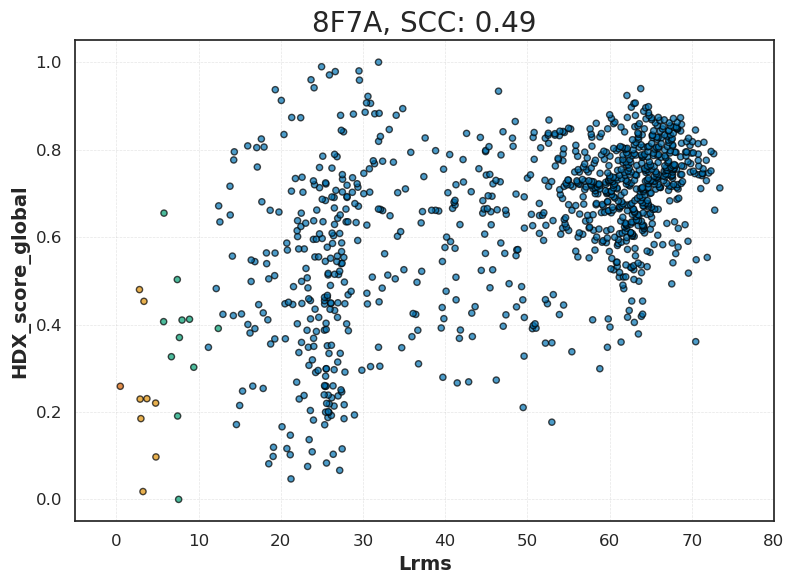

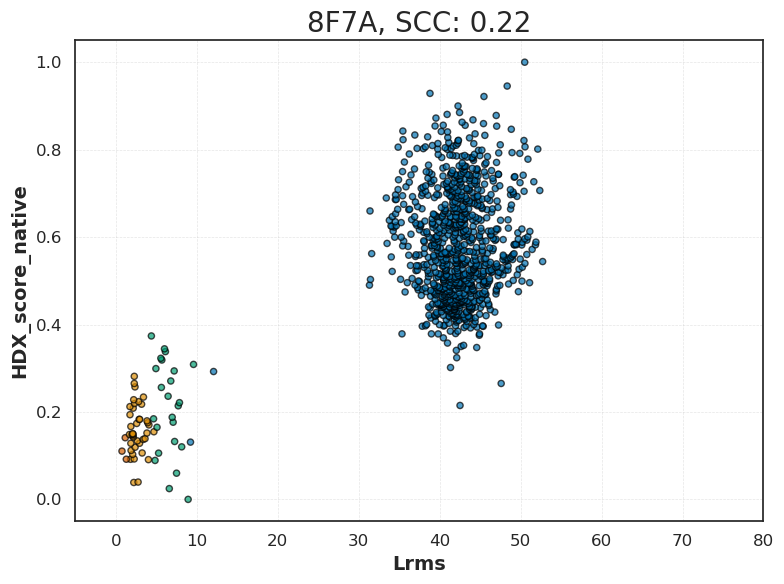

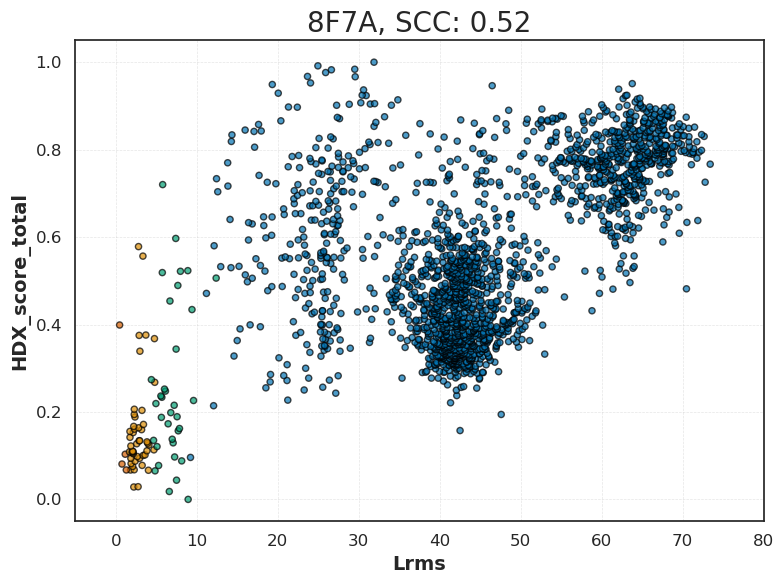

In [16]:
hdx_score_df = pd.DataFrame(HDX_scores.items(), columns=['model', 'HDX_score'])
merge_df = pd.merge(dockq_df, hdx_score_df, on='model')
merge_df = merge_df.sort_values(by='HDX_score')
display(merge_df)

merge_df = classify_by_dockq(merge_df, dockq_col='DockQ')
temp_global_df = merge_df[merge_df['model'].str.contains('REVISED')]
temp_native_df = merge_df[merge_df['model'].str.contains('NATIVE')]
plot_score(temp_global_df, ref_col='Lrms', score_col='HDX_score', x_label='Lrms', y_label='HDX_score_global', protein_name=protein_name, x_max=80, save_fig=True)
plot_score(temp_native_df, ref_col='Lrms', score_col='HDX_score', x_label='Lrms', y_label='HDX_score_native', protein_name=protein_name, x_max=80, save_fig=True)
plot_score(merge_df, ref_col='Lrms', score_col='HDX_score', x_label='Lrms', y_label='HDX_score_total', protein_name=protein_name, x_max=80, save_fig=True)

hdx_time = ",".join([str(t) for t in hdx_times])
#merge_df['HDX_time'] = hdx_time
merge_df.to_csv(f'{root_dir}/{task_folder}/HDX_scores_2.csv', index=False)

In [17]:
test_df = merge_df[merge_df['model'].str.contains('REVISED')]
test_df = test_df.sort_values(by='HDX_score')
display(test_df.head())

,DockQ,irms,Lrms,fnat,classification,model,zrank2_score,zrank_score,rosetta_score,HDX_score
0,0.336872,3.987217,7.576991,0.329412,1,MODEL_20_REVISED,-0.689023,-78.8185,3719.053,0.031277
4,0.669413,1.465672,3.240037,0.623529,2,MODEL_2_REVISED,-57.418100,-75.4165,3253.906,0.031720
46,0.075714,10.903505,21.245583,0.070588,0,MODEL_196_REVISED,221.735000,-70.5892,4264.169,0.032434
25,0.048563,15.329636,27.170200,0.047059,0,MODEL_646_REVISED,-10.013500,-47.8154,3157.663,0.032918
10,0.041996,16.441638,23.268588,0.000000,0,MODEL_378_REVISED,45.536600,-44.5788,3925.426,0.033138


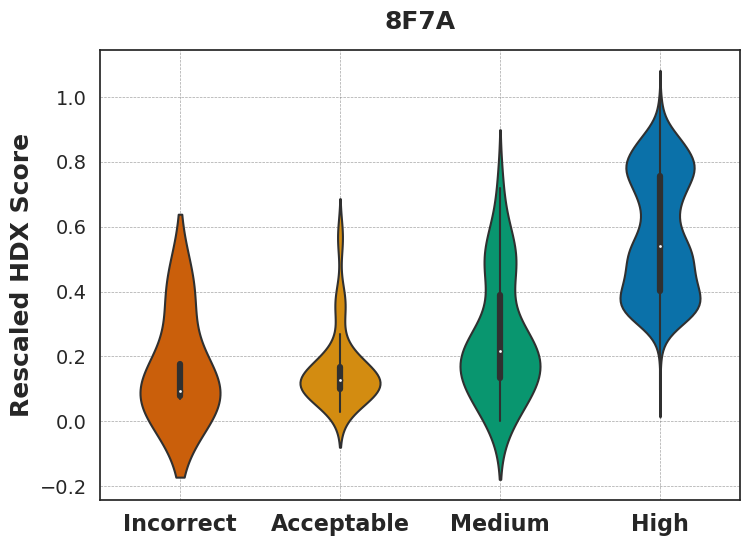

Incorrect:0.0960
Acceptable:0.0000
Medium:0.0283
High:0.0673


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Assume merge_df is pre-loaded
score_df = merge_df.copy()

# Min-Max Scaling Function
def max_min_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Apply Scaling
score_df['rescale_HDX_score'] = max_min_scale(score_df['HDX_score'].to_numpy())

# Set theme
sns.set_theme(style="white")
boxprops = dict(linestyle='-', linewidth=2, color='#00145A')
flierprops = dict(marker='o', markersize=4, linestyle='none')
whiskerprops = dict(linestyle='-', linewidth=2, color='#00145A')
capprops = dict(linestyle='-', linewidth=2, color='#00145A')
medianprops = dict(linestyle='-', linewidth=2, color='#FF4500')

# Define color palette
palette = {0: '#0273b2', 1: '#019e73', 2: '#de8f06', 3: '#d55e00'}
legend_labels = {0: 'Incorrect', 1: 'Acceptable', 2: 'Medium', 3: 'High'}
custom_palette = [palette[i] for i in range(3, -1, -1)]
plot_labels = ['Incorrect', 'Acceptable', 'Medium', 'High']
order = [3, 2, 1, 0]

'''legend_labels = {0: 'Incorrect', 1: 'Acceptable'}
custom_palette = [palette[i] for i in range(1, -1, -1)]
plot_labels = ['Incorrect', 'Acceptable']
order = [1, 0]'''

# Initialize Figure
plt.figure(figsize=(8, 6))

# Violin Plot
sns.violinplot(
    x='classification',
    y='rescale_HDX_score',
    data=score_df,
    palette=custom_palette,  
    order=order,
    flierprops=flierprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    showmeans=True,
    meanline=True,
    width=0.5,
    saturation=0.9,
    scale='width'
)

# Labels & Title
plt.ylabel('Rescaled HDX Score', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.title(f'{protein_name[:4]}', fontsize=18, fontweight='bold', pad=15)

# Ticks & Grid
plt.xticks(ticks=[0,1,2,3], labels=plot_labels, fontsize=16, weight='bold')
plt.yticks(fontsize=14)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

# Fine-tuned Grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
#plt.grid(True, which='minor', linestyle=':', linewidth=0.3, color='gray', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)

# Show Plot
plt.show()
#plt.savefig(f'{root_dir}/{task_folder}/{protein_name}_CAPRI_violin.png', dpi=300)

# Print Mean Values by Classification
grouped = score_df.groupby('classification')
for name, group in grouped:
    print(f"{legend_labels[name]}:{group['rescale_HDX_score'].min():.4f}")


In [144]:

protein_name = '1UGH'
work_dir = f"/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/{protein_name}_docking"

merge_df = pd.read_csv(f'{work_dir}/HDX_scores.csv')
merge_df['Batch'] = merge_df['model']
merge_df.drop(columns=['model'], inplace=True)

energy_df = pd.read_csv(f'{work_dir}/{protein_name}_decoy_scores.csv')
print(energy_df.columns)
energy_df = energy_df[['Batch', 'zrank2_score', 'zrank_score', 'rosetta_score']]

merge_df = pd.merge(merge_df, energy_df, on='Batch')
display(merge_df)
merge_df.to_csv(f'{work_dir}/HDX_scores.csv', index=False)

Index(['Batch', 'Chain', 'Range', 'Y_True', 'Y_Pred', 'HDX_score_time',
       'HDX_score', 'LRMS', 'iRMS', 'fnat', 'classification', 'zrank2_score',
       'zrank_score', 'rosetta_score_x', 'rosetta_score_y', 'rosetta_score'],
      dtype='object')


,DockQ,irms,Lrms,fnat,HDX_score,classification,HDX_time,Batch,zrank2_score,zrank_score,rosetta_score
0,0.937331,0.330537,0.741397,0.865854,0.076837,3,3000,MODEL_90_NATIVE,-274.30100,-113.3220,-56.587
1,0.948274,0.258822,0.559539,0.878049,0.076887,3,3000,MODEL_422_NATIVE,-262.17600,-115.4700,-45.420
2,0.921707,0.400873,0.840492,0.841463,0.077003,3,3000,MODEL_259_NATIVE,-258.51600,-111.0840,-146.765
3,0.925841,0.466888,0.944685,0.878049,0.077334,3,3000,MODEL_554_NATIVE,-287.25200,-120.9470,-148.475
4,0.958798,0.230526,0.463915,0.902439,0.077483,3,3000,MODEL_843_NATIVE,-265.79500,-112.7090,-188.063
...,...,...,...,...,...,...,...,...,...,...,...
1995,0.009911,20.643224,53.657399,0.000000,0.166595,0,3000,MODEL_286_REVISED,8.77095,-34.3750,238.027
1996,0.009993,18.693351,54.694579,0.000000,0.167110,0,3000,MODEL_373_REVISED,304.32300,-58.2920,681.897
1997,0.015477,16.050034,42.900682,0.000000,0.167885,0,3000,MODEL_934_REVISED,19.43310,-37.2245,-50.972
1998,0.016118,16.870140,41.368026,0.000000,0.168001,0,3000,MODEL_964_REVISED,-65.99110,-34.7584,-237.203


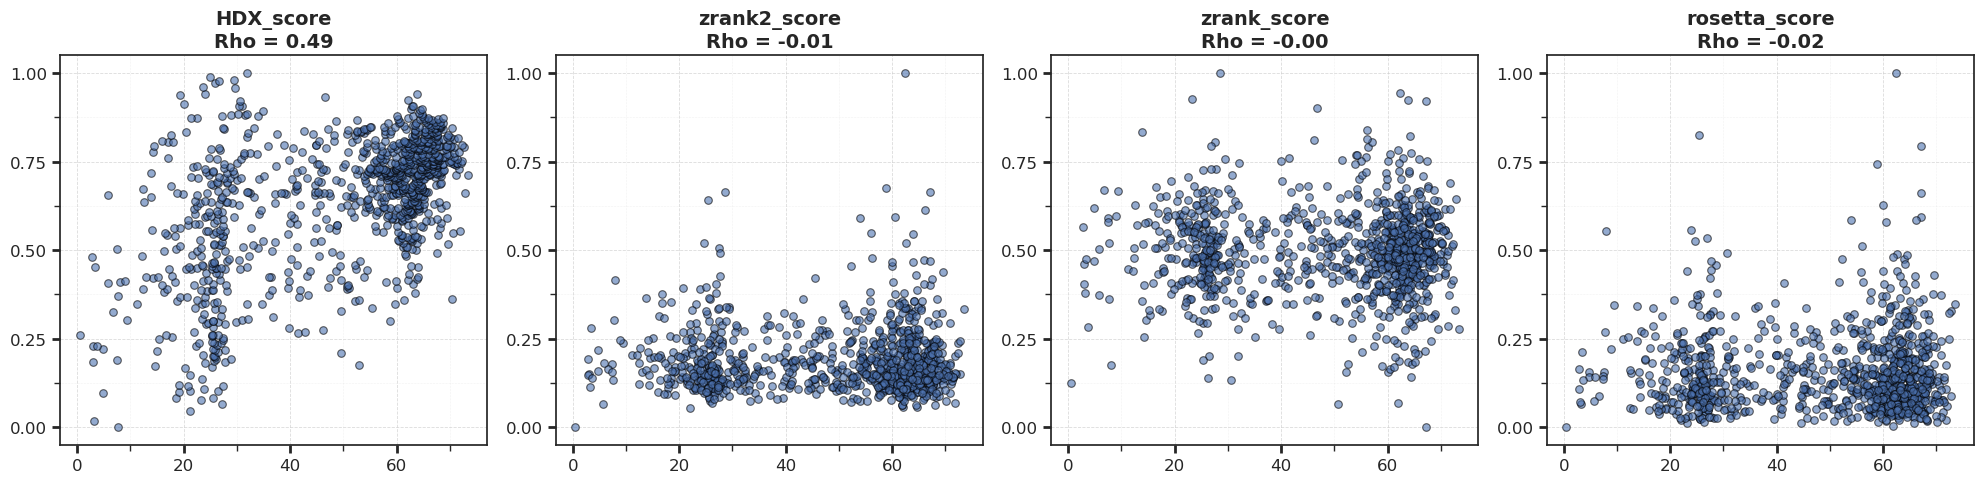

In [20]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

protein_name = '8F7A'
work_dir = f"/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/{protein_name}_docking"
merge_df = pd.read_csv(f'{work_dir}/HDX_scores_2.csv')

# Function to min-max scale a series
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

# Columns to plot
score_cols = ['HDX_score', 'zrank2_score', 'zrank_score', 'rosetta_score']
merge_df = merge_df[merge_df['model'].str.contains('REVISED')]
# Rescale Scores
for col in score_cols:
    merge_df[f'rescaled_{col}'] = min_max_scale(merge_df[col])

# Create figure and subplots
sns.set_theme(style="ticks")
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False)

# Plot each score vs. Lrms
for i, sc in enumerate(score_cols):
    rho, p = st.spearmanr(merge_df['Lrms'], merge_df[sc])
    
    # Scatter plot
    axs[i].scatter(merge_df['Lrms'], merge_df[f'rescaled_{sc}'], 
                   alpha=0.6, edgecolor='black', s=30, linewidth=0.8)

    # Title with correlation coefficient
    axs[i].set_title(f"{sc}\nRho = {rho:.2f}", fontsize=14, fontweight='bold')

    # Major Ticks for both x and y
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(5))  # Control major ticks
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Minor Ticks
    axs[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))

    # Grid Styling
    axs[i].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    axs[i].grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    # Label Fonts
    axs[i].tick_params(axis='both', which='major', length=6, width=2, labelsize=12)

    #set x range from -5 to 100
    #axs[i].set_xlim(-5, 60)

# Layout Adjustment
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import shutil
import os

protein_name = '8A0E'
work_dir = f"/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/{protein_name}_docking"
merge_df = pd.read_csv(f'{work_dir}/HDX_scores.csv')
merge_df = merge_df[merge_df['Batch'].str.contains('REVISED')]
merge_df.sort_values(by='HDX_score', inplace=True)
display(merge_df.head(10))

top5_models = merge_df['Batch'].head(5).values
print(top5_models)
os.makedirs(f'{work_dir}/{protein_name}_top5_models', exist_ok=True)
for file in top5_models:
    shutil.copy(f'{work_dir}/structures/{file}.pdb', f'{work_dir}/{protein_name}_top5_models/{file}.pdb')

,DockQ,irms,Lrms,fnat,HDX_score,classification,HDX_time,Batch,zrank2_score,zrank_score,rosetta_score
1000,0.004693,22.708443,85.724786,0.0,0.090969,0,10000,MODEL_917_REVISED,218.2390,-49.8076,792.040
1001,0.005811,23.728308,72.789515,0.0,0.091145,0,10000,MODEL_788_REVISED,288.4190,-50.6910,1647.164
1002,0.004258,24.070665,89.673540,0.0,0.092242,0,10000,MODEL_362_REVISED,121.6670,-29.6340,497.022
1003,0.007233,24.659430,62.761357,0.0,0.092450,0,10000,MODEL_308_REVISED,-43.3145,-39.2558,265.069
1004,0.004554,23.665274,86.056718,0.0,0.093332,0,10000,MODEL_857_REVISED,100.1180,-63.8750,585.415
1005,0.014882,16.955241,43.438090,0.0,0.093578,0,10000,MODEL_524_REVISED,676.3620,-17.1696,1847.455
1006,0.006553,20.741358,70.181526,0.0,0.093702,0,10000,MODEL_302_REVISED,356.1810,-57.4132,1018.448
1007,0.004588,23.629733,85.661351,0.0,0.093721,0,10000,MODEL_443_REVISED,327.1800,-37.6858,1060.941
1008,0.005512,24.588240,74.566861,0.0,0.093753,0,10000,MODEL_108_REVISED,566.7110,-41.9241,1605.818
1009,0.017756,10.528488,45.745603,0.0,0.093843,0,10000,MODEL_72_REVISED,46.5982,-25.7247,413.583


['MODEL_917_REVISED' 'MODEL_788_REVISED' 'MODEL_362_REVISED'
 'MODEL_308_REVISED' 'MODEL_857_REVISED']


In [29]:
import pandas as pd

work_dir = '/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/Model/compare/test'
model_name = "GVP"
cls_name = 'test_cls0'

pred_prefix = f'{work_dir}/prediction_{cls_name}_{model_name}'
dfs = []
for i in range(5):
    pred_fpath = f'{pred_prefix}_v{i}_metrics.csv'
    pred_df = pd.read_csv(pred_fpath)
    dfs.append(pred_df)
df_all = pd.concat(dfs, axis=0)
stats_df = df_all.groupby('Batch')[['rho', 'rmse']].agg(['mean', 'std']).reset_index()
stats_df.columns = ['Batch', 'rho_mean', 'rho_std', 'rmse_mean', 'rmse_std']
pd.options.display.float_format = '{:.3f}'.format
display(stats_df)
print(f"{stats_df['rho_mean'].mean():3f}", f"{stats_df['rmse_mean'].mean():3f}")

,Batch,rho_mean,rho_std,rmse_mean,rmse_std
0,1UGH,0.376,0.081,0.290,0.056
1,3DVL,0.364,0.082,0.150,0.024
2,3KVD,0.264,0.205,0.251,0.028
3,4KSO,0.833,0.024,0.128,0.017
4,6DJL,NaN,NaN,1.185,0.011
5,6SB0_CDY,0.293,0.129,0.705,0.026
6,8A0E,0.613,0.074,0.183,0.026
7,8F7A,0.179,0.127,0.275,0.021


0.417439 0.395880
